<a href="https://colab.research.google.com/github/sayanbanerjee32/TSAI_ERAv2_S6/blob/main/ERAv2_S6_P2_SayanBanerjee_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Import all required packages

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

## Check if GPU available

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## The model architecture

In [ ]:
class Net(nn.Module):
    def __init__(self,n = 8):
        super(Net, self).__init__()
        # Convolusion Block - Inital
        #input size: 28 x 28 x 1, output size: 28 x 28 x n, receptive field: 3
        self.convi = nn.Conv2d(1, n, 3, padding=1, bias = False)
        self.bni = nn.BatchNorm2d(n)

        # Convolusion Block - feature extraction
        #input size: 28 x 28 x n, output size: 28 x 28 x n*2, receptive field: 3 + (3-1) * 1 = 5
        self.conv1 = nn.Conv2d(n, n*2, 3, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(n*2)
        #input size: 28 x 28 x n*2, output size: 28 x 28 x n*4, receptive field: 5 + (3-1) * 1 = 7
        self.conv2 = nn.Conv2d(n*2, n*4, 3, padding=1, bias = False)
        self.bn2 = nn.BatchNorm2d(n*4)

        # Transition block - reduction in channel size and number
        #input size: 28 x 28 x n*4, output size: 14 x 14 x n*4, receptive field: 7 + (3-1) * 1 = 8
        self.pool1 = nn.MaxPool2d(2, 2)
        #input size: 14 x 14 x n*4, output size: 14 x 14 x n, receptive field: 8 + (1-1)*2 = 8
        self.antman1 = nn.Conv2d(n*4, n, kernel_size=1,bias = False)
        self.bna1 = nn.BatchNorm2d(n)

        # Convolusion Block - feature extraction
        #input size: 14 x 14 x n, output size: 14 x 14 x n*2, receptive field: 8 + (3-1) * 2 = 12
        self.conv3 = nn.Conv2d(n, n*2, 3, padding=1, bias = False)
        self.bn3 = nn.BatchNorm2d(n*2)
        #input size: 14 x 14 x n*2, output size: 14 x 14 x n*4, receptive field: 12 + (3-1) * 2 = 16
        self.conv4 = nn.Conv2d(n*2, n*4, 3, padding=1, bias = False)
        self.bn4 = nn.BatchNorm2d(n*4)

        # Transition block - reduction in channel size and number
        #input size: 14 x 14 x n*4, output size: 7 x 7 x n*4, receptive field: 16 + (2-1) * 2 =18
        self.pool2 = nn.MaxPool2d(2, 2)
        #input size: 7 x 7 x n*4, output size: 7 x 7 x n, receptive field: 18 + (1-1) * 4 =18
        self.antman2 = nn.Conv2d(n*4, n, kernel_size=1, bias = False)
        self.bna2 = nn.BatchNorm2d(n)

        # Convolusion Block - feature extraction
        #input size: 7 x 7 x n, output size: 7 x 7 x n*2, receptive field: 18 + (3-1) * 4 = 26
        self.conv5 = nn.Conv2d(n, n*2, 3, padding=1, bias = False)
        self.bn5 = nn.BatchNorm2d(n*2)
        #input size: 7 x 7 x n*2, output size: 7 x 7 x n*4, receptive field: 26 + (3-1) * 4 = 34
        self.conv6 = nn.Conv2d(n*2, n*4, 3, padding=1, bias = False)
        self.bn6 = nn.BatchNorm2d(n*4)

        # Transition block - - reduction in channel size
        # and aligning number of channels to number of prediction classes
        #input size: 7 x 7 x n*4, output size: 3 x 3 x n*4, receptive field: 34 + (2-1) * 4 = 38
        self.pool3 = nn.MaxPool2d(2, 2)
        #input size: 3 x 3 x n*4, output size: 3 x 3 x 10, receptive field: 38 + (1-1) * 8 = 38
        self.antman3 = nn.Conv2d(n*4, 10, kernel_size=1, bias = False)

    def forward(self, x):
        x = self.bni(F.relu(self.convi(x))) #28 x 28

        x = self.bn1(F.relu(self.conv1(x))) #28 x 28
        x = self.bn2(F.relu(self.conv2(x))) #28 x 28
        x = self.bna1(self.antman1(self.pool1(x))) #14 x 14
        # dropout of 0.25 was not allowing model to train to the required level
        # thus dropout is set to 0.1
        x = F.dropout(x, 0.10) #14 x 14

        x = self.bn3(F.relu(self.conv3(x))) #14 x 14
        x = self.bn4(F.relu(self.conv4(x))) #14 x 14
        x = self.bna2(self.antman2(self.pool2(x))) #7 x 7
        # dropout of 0.25 was not allowing model to train to the required level
        # thus dropout is set to 0.1
        x = F.dropout(x, 0.10) #7 x 7

        x = self.bn5(F.relu(self.conv5(x))) #7 x 7
        x = self.bn6(F.relu(self.conv6(x))) #7 x 7
        x = self.antman3(self.pool3(x)) #3 x 3

        # Global average pooling instead of FC layer
        #input size: 3 x 3 x 10, output size: 1 x 1 x 10 > len of 10
        x = F.avg_pool2d(x, kernel_size = 3).squeeze()

        # x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        # x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        # x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        # x = x.view(-1, 10)
        return F.log_softmax(x)

In [ ]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 28, 28]           1,152
       BatchNorm2d-4           [-1, 16, 28, 28]              32
            Conv2d-5           [-1, 32, 28, 28]           4,608
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             256
       BatchNorm2d-9            [-1, 8, 14, 14]              16
           Conv2d-10           [-1, 16, 14, 14]           1,152
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 32, 14, 14]           4,608
      BatchNorm2d-13           [-1, 32, 14, 14]              64
        MaxPool2d-14             [-1, 3

<ipython-input-3-00a8ce833243>:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Train and Test transformations

In [ ]:
torch.manual_seed(1)
# tries batch size of 64, 256 and 512 as well
batch_size = 128

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                    transforms.Resize((28, 28)),
                    transforms.RandomRotation((-15., 15.), fill=0),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 123859989.94it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 130534152.83it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41331839.62it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4476158.08it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Training

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [ ]:
## Functions for training and testing steps that will be called for each epoch
from tqdm import tqdm
## Return prediction count based on model prediction and targe
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

### train function that will be called for each epoch
def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # move all data to same device
    data, target = data.to(device), target.to(device)
    # No gradient accumulation
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    # difference between molde prediction and target values based on criterion function provided as input
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    # takes a step, i.e. updates parameter values based on gradients
    # these parameter values will be used for the next batch
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)
    # Shows traing progress with loss and accuracy update for each batch
    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

### test function that will be called for each epoch
def test(model, device, test_loader, criterion):
    # switching on eval / test mode - dropouts will not be considered
    model.eval()

    test_loss = 0
    correct = 0
    # no gradient calculation is required for test
    ## as parameters are not updated while test
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # Calculate test loss -
            # difference between molde prediction and target values based on criterion function provided as input
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    # print test loss and accuracy after each epoch
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Multi step LR scheduler to reduce learning rate in 2 different intervals
# so that higher epochs can be trained with lower learning rate
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,16], gamma=0.1, verbose=True)

# criterion = nn.CrossEntropyLoss()
criterion = F.nll_loss
# F.cross_entropy
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-3-00a8ce833243>:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Train: Loss=0.1302 Batch_id=468 Accuracy=88.87: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]


Test set: Average loss: 0.0738, Accuracy: 9792/10000 (97.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0573 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]


Test set: Average loss: 0.0477, Accuracy: 9841/10000 (98.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1534 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Test set: Average loss: 0.0498, Accuracy: 9854/10000 (98.54%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0458 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Test set: Average loss: 0.0366, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0647 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Test set: Average loss: 0.0342, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0840 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]


Test set: Average loss: 0.0307, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0320 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0186 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]


Test set: Average loss: 0.0273, Accuracy: 9915/10000 (99.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0378 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0318 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0024 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0075 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]


Test set: Average loss: 0.0175, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.0120 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.0153 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0165 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0046 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]


Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17


Train: Loss=0.0049 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18


Train: Loss=0.0128 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Test set: Average loss: 0.0177, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 19


Train: Loss=0.0499 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]


Test set: Average loss: 0.0172, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 20


Train: Loss=0.0052 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-04.


# Visualise training and test losses and accuracies

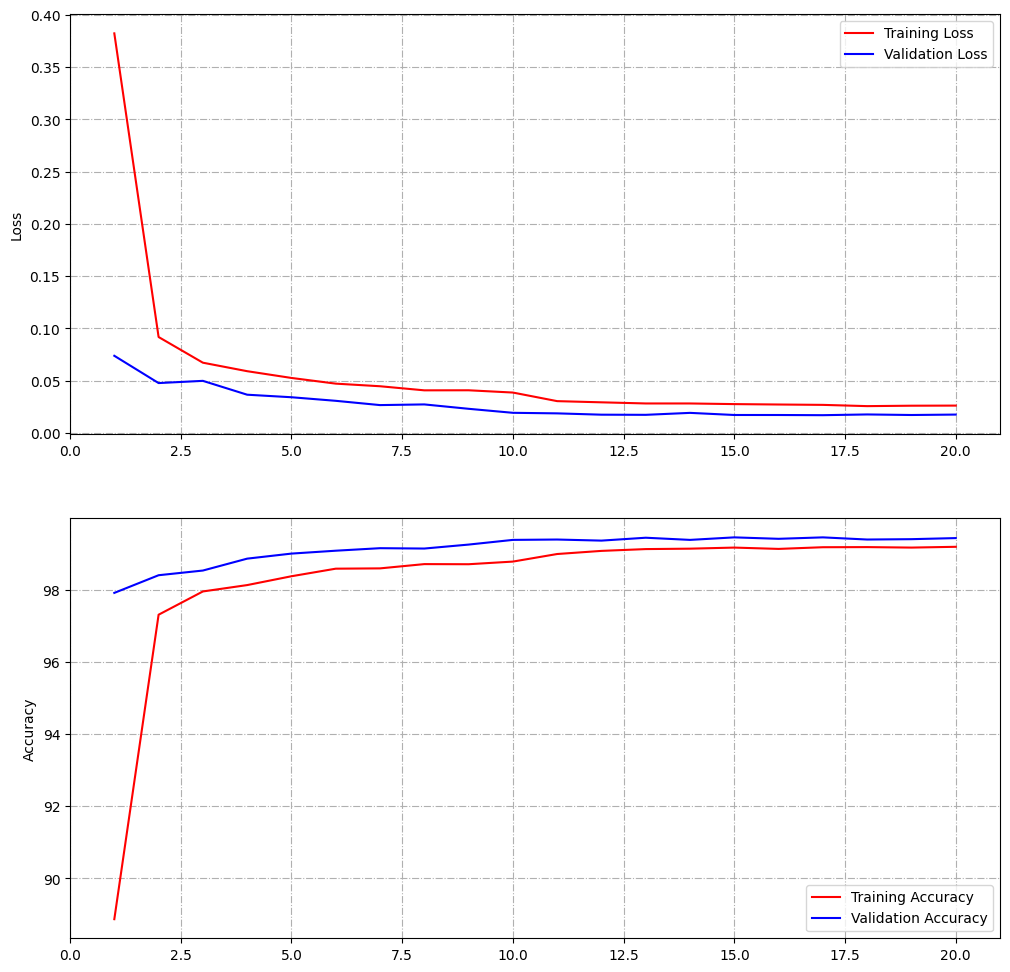

In [ ]:
# plot training history
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, num_epochs + 1])
plt.ylabel('Loss')
plt.plot(range(1, num_epochs + 1), train_losses[:num_epochs+1], 'r', label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses[:num_epochs+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, num_epochs+1])
plt.ylabel('Accuracy')
plt.plot(range(1, num_epochs + 1), train_acc[:num_epochs+1], 'r', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_acc[:num_epochs+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()